In [5]:
# Perform the initialization and imports
import sys
import pickle
import re
import os
import csv
import argparse
import math
import random

from string import ascii_lowercase
from collections import Counter, defaultdict, OrderedDict
from operator import itemgetter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from scipy.sparse import issparse
import matplotlib.ticker as plticker
import numpy.linalg as la
import scipy.cluster.vq as vq
from matplotlib_venn import venn2

from networkx.algorithms import community
import community as community_louvain

from Bio import SeqIO, AlignIO
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio.Emboss.Applications import NeedleallCommandline

In [6]:
# Retrieve the specific functions from ind and proteins.py
indels_path="/home/maya/InDelScanner"  # /PATH/TO/InDelScanner
if indels_path not in sys.path:
    sys.path.append(indels_path)

from ipynb.fs.defs.Library_diversity import convert_variant_to_dict, single_fraction_enrichment

os.chdir("/mnt/c/Users/Maya/Dropbox/mek_results")

# Set general restrictions stemming from SpliMLib library design
aa_2 = ['A', 'Δ']
aa_12 = ['A','G','P','Y','D','K','M','V','I','L','F','W']
aa_13 = aa_12 +  ['Δ']
pos_aa = {'6': aa_12, '9': aa_12, '11': aa_12, '13': aa_12, '7a': aa_13, '8a': aa_2}

In [7]:
with open('mek_counter.pickle', 'rb') as pf:
    mek = pickle.load(pf)

with open('df_pos.pickle', 'rb') as pf:
    df_pos = pickle.load(pf)
    
pos = df_pos.to_dict()

In [8]:
factors = pd.read_pickle('mkk_factors.gzip')

## Sequence similarity network analysis with NetworkX

This section examines the largest connected subgraph in the Hamming distance graph, with 31,259 nodes and 193K edges. This is by far the largest connected subgraph in the network, as the next largest contains only 5 nodes. The graph was generated in another file and annotated with node degree, betweenness and centrality scores.

https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

In [15]:
G = nx.read_graphml('connected_annotated.graphml')

In [16]:
# AVERAGE NODE DEGREE
G.size()/G.order()

6.180236092005503

### Is the network of active variants scale free?

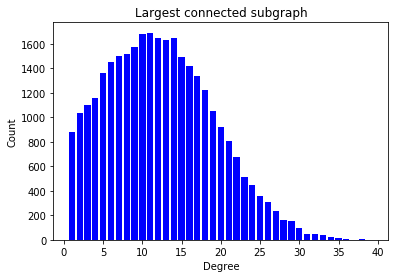

In [17]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')

plt.title("Largest connected subgraph")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

Interestingly, this network does not appear to be scale free. To be clearer, let's plot the number of nodes with a given degree against log(degree). If the network is scale free, that should give a straight line.

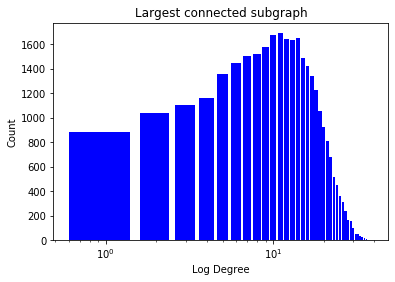

In [18]:
fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color='b')
ax.set_xscale('log')

plt.title("Largest connected subgraph")
plt.ylabel("Count")
plt.xlabel("Log Degree")
plt.show()

In [20]:
density = nx.density(G)
print("Network density:", density)

triadic_closure = nx.transitivity(G)
print("Triadic closure:", triadic_closure)

Network density: 0.00039543387881537545
Triadic closure: 0.2189614679163732


This network is quite sparsely connected, but the closure between nodes is relatively high. It's not scale free. The diameter of the network is 16, so any pair of nodes is connected by 16 or fewer edges (longest of the shortest paths).

### Which are the important nodes in this network?

In [21]:
n = 316 # top 1% of nodes

In [22]:
close = nx.get_node_attributes(G, 'closeness')
deg = nx.get_node_attributes(G, 'deg')
betw = nx.get_node_attributes(G, 'betweenness')

In [23]:
with open('H_eigenvector_centrality.pickle', 'rb') as f:
    eig_cen = pickle.load(f)

nx.set_node_attributes(G, eig_cen, 'eigenvector')

In [24]:
top_degree = [k[0] for k in sorted(deg.items(), key=itemgetter(1), reverse=True)[:n]]
top_close = [k[0] for k in sorted(close.items(), key=itemgetter(1), reverse=True)[:n]]
top_betw = [k[0] for k in sorted(betw.items(), key=itemgetter(1), reverse=True)[:n]]

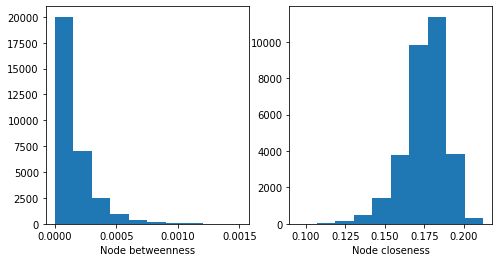

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

# betweenness
ax = axes[0]
ax.hist(betw.values())
ax.set_xlabel('Node betweenness')

# closeness
ax = axes[1]
ax.hist(close.values())
ax.set_xlabel('Node closeness')

plt.show()

The above graphs indicate that node betweenness is a rather useless measure (betwenness ranges between 0 and 1, yet here all nodes have betweenness < 0.0015). However, there is a more useful distribution in node closeness and degree centrality, so let's examine those in more detail.

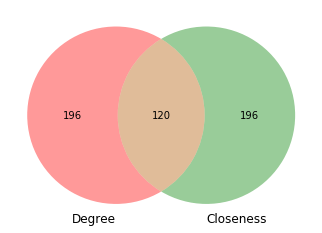

In [26]:
venn2([set(top_degree), set(top_close)], set_labels = ('Degree', 'Closeness'))
plt.show()

### Quick and dirty way for finding modules within the network

In [27]:
communities = community.greedy_modularity_communities(G)

In [43]:
len(communities)

51

In [28]:
for i in communities[:10]:
    print(len(i))

8615
7576
7172
5745
1908
46
13
12
7
7


In [29]:
modularity_dict = {} # Create a blank dictionary
for i,c in enumerate(communities): # Loop through the list of communities, keeping track of the number for the community
    for name in c: # Loop through each person in a community
        modularity_dict[name] = i # Create an entry in the dictionary for the person, where the value is which group they belong to.

# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, modularity_dict, 'modularity')

There are five large subpopulations in this graph, so let's have a look at their core nodes and the composition of each of these.

In [30]:
cluster_dfs = {i: df_pos.loc[communities[i]] for i in range(5)}
connected_df = df_pos.loc[list(G.nodes())]

In [120]:
def plot_clusters(full_df, dfs, ax_lims, log_function, fname='', fsize=(12,6)):
    
    cbar_ticks = [ax_lims[0], ax_lims[0]/2, 0, ax_lims[1]/2, ax_lims[1]]
    
    fig, axes = plt.subplots(2, len(dfs) +1,  figsize=fsize, gridspec_kw={'wspace':0.3, 'hspace':0.3})

    cnts = single_fraction_enrichment(full_df, 'high', 1, proportion=False)
    df_all = pd.DataFrame.from_dict(cnts).reindex(aa_13)
    log_df = (df_all/(df_all.sum()/df_all.astype(bool).sum())).apply(log_function)   
    sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=axes[0][0], cmap="RdBu_r", cbar=False)
    
    axes[1][0].axis('off')
    
    for i in range(len(dfs)):
        
        cnts = single_fraction_enrichment(dfs[i], 'high', 1, proportion=False)
        df_restrict = pd.DataFrame.from_dict(cnts).reindex(aa_13)

        # first plot the top
        ax = axes[0][i+1]
        
        log_df = (df_restrict/(df_restrict.sum()/df_restrict.astype(bool).sum())).apply(log_function)   
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=ax, cmap="RdBu_r", cbar=False)

        # now plot the change relative to overall preference
        ax = axes[1][i+1]
        top_df = df_restrict/df_restrict.sum()    
        b_df = df_all/df_all.sum()
        log_df = (top_df/b_df).apply(log_function)           
    
        sns.heatmap(log_df, vmin=ax_lims[0], vmax=ax_lims[1], linewidths=0.2, ax=ax, cmap="RdBu_r", cbar=False)
        
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=300)
    plt.show()

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


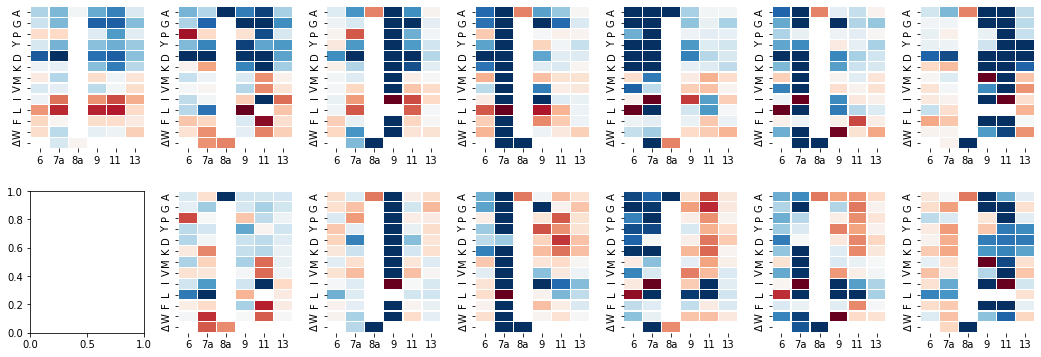

In [112]:
plot_clusters(connected_df, cluster_dfs, (-2, 2),  np.log2, fname='', fsize=(18,6))

### Better way of partitioning the graph

Seeing that the clusters are sensible, now check more propertly if the network can partition in a sensible way: range -0.5 to 1.

In [33]:
best_communities = community_louvain.best_partition(G)
global_modularity = community_louvain.modularity(best_communities, G)
print(global_modularity)

0.6880763156743762


In [40]:
print(max(best_communities.values()))

13


In [44]:
# Now you can add modularity information like we did the other metrics
nx.set_node_attributes(G, best_communities, 'louvain')

In [46]:
nx.write_graphml(G, "hamming_partitioned.graphml")  

In [35]:
subgraph_dict = {i: [nd for nd in G.nodes() if G.nodes[nd]['modularity'] == i] for i in range(11)}

cluster_dfs = {i: df_pos.loc[subgraph_dict[i]] for i in range(11)}
connected_df = df_pos.loc[list(G.nodes())]

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


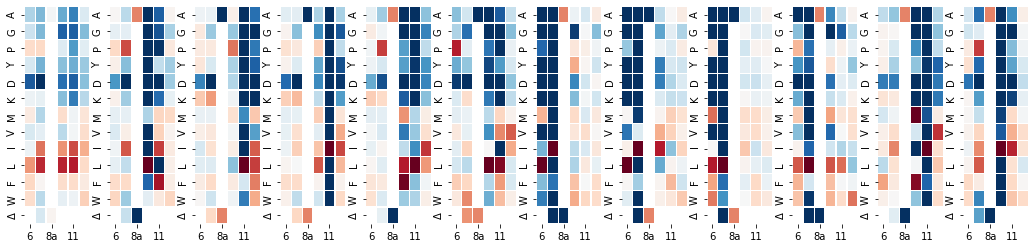

In [36]:
plot_clusters(connected_df, cluster_dfs, (-2, 2),  np.log2, fname='', fsize=(18,4))

Therefore, the Louvain partitioning algorithm splits the graph into 14 separate communities. The Louvain algorithm guarantees that each node is well connected to its own community, but it does have an issue in that some communities might be poorly connected to itself (that is, missing a bridge within the community). This mis-assignment can happen if the bridge within a community is also well connected outside of it, so it gets reassigned to the outside community. However, that leaves the original community 'divided', yet the Louvain method cannot split it into two proper communities.

### Leiden method.

In [9]:
import leidenalg
import igraph as ig

In [10]:
H = ig.read("hamming_partitioned.graphml")

In [52]:
leiden = leidenalg.find_partition(H, leidenalg.ModularityVertexPartition, n_iterations=25)

In [62]:
for i in range(19):
    print(len(leiden[i]))

4457
3976
3508
3395
3194
2846
2842
2434
2015
1923
628
9
7
5
4
4
4
4
4


11 of the 19 clusters have substantial membership. Assign the leiden community membership to the graph and then export it for plotting in Gephi.

In [79]:
leiden_memb = {}

for com in range(19):
    for v in leiden[com]:
        leiden_memb[v] = com

leiden_sorted = OrderedDict(sorted(leiden_memb.items()))
H.vs['leiden'] = list(leiden_sorted.values())

In [92]:
H.write_graphml('Hamming_with_Leiden.graphml')

In [97]:
len(H.vs)

31259

In [32]:
H.vs[0]

igraph.Vertex(<igraph.Graph object at 0x7f99dca73048>, 0, {'louvain': 0.0, 'modularity': 0.0, 'eigenvector': 0.02325004252893375, 'betweenness': 0.0007710451028406138, 'closeness': 0.19745303399744799, 'deg': 34.0, 'id': '6L/7aI/8aA/9L/11F/13M'})

In [113]:
subgraph_dict = {i: [H.vs[nd]['id'] for nd in range(len(H.vs)) if H.vs[nd]['leiden'] == i] for i in range(5)}

cluster_dfs = {i: df_pos.loc[subgraph_dict[i]] for i in range(5)}
connected_df = df_pos.loc[list(G.nodes())]

/home/maya/miniconda3/envs/InDelScanner/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


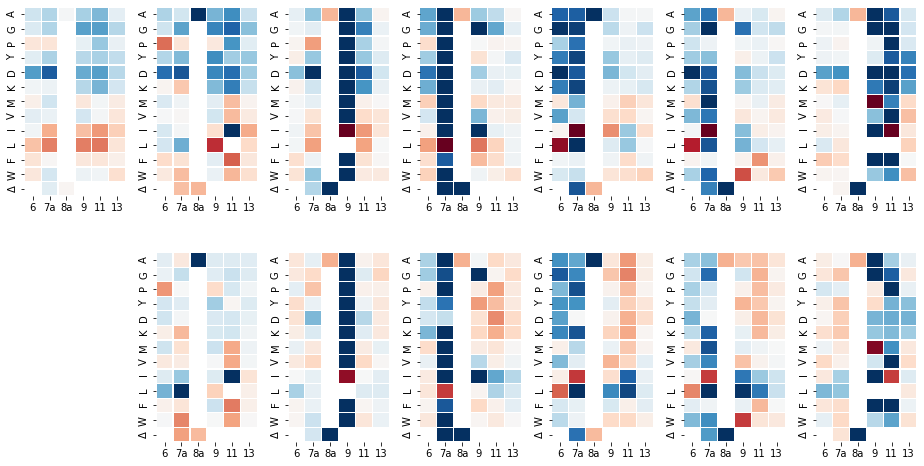

In [122]:
plot_clusters(connected_df, cluster_dfs, (-3, 3),  np.log2, fname='Leiden_clusters_0-4.svg', fsize=(16,8))

- 0: 8aΔ/11L
- 1: 8aA/9L
- 2: 8aΔ/11L
- 3: 6 hydrophobic/7aL/8aΔ
- 4: 9FM/11L

In [31]:
subgraph_dict = {i: [H.vs[nd]['id'] for nd in range(len(H.vs)) if H.vs[nd]['leiden'] == i] for i in range(5,11)}

cluster_dfs = {i-5: df_pos.loc[subgraph_dict[i]] for i in range(5,11)}
connected_df = df_pos.loc[list(G.nodes())]

plot_clusters(connected_df, cluster_dfs, (-3, 3),  np.log2, fname='Leiden_clusters_5-10.svg', fsize=(18,8))

KeyError: 'Attribute does not exist'

- 5: 6P/8aΔ/9L/11F
- 6: 8aA/9I
- 7: 7aL/8aA
- 8: 6L/7aI/8aΔ
- 9: 6L/7aI/8aA/9W
- 10: 9M/11I

### Finds cluster location for ten most abundant high gate variants

In [34]:
H = ig.read('Hamming_with_Leiden.graphml')

In [1]:
toplib = ['6L/7aI/8aA/9L/11F/13M',
 '6F/7aP/9W/11L/13M',
 '6L/7aF/9L/11I/13I',
 '6A/7aI/8aA/9L/11L/13I',
 '6W/7aI/9F/11L/13V',
 '6A/7aP/8aA/9L/11V/13W',
 '6L/7aI/8aA/9M/11W/13W',
 '6V/7aP/8aA/9F/11F/13M',
 '6A/7aK/9L/11L/13W',
 '6A/7aI/8aA/9L/11V/13M',
 '6P/9I/11L/13P',
 '6P/9A/11A/13P',
 '6L/7aL/9L/11L/13I']

In [35]:
for v in toplib:
    try:
        print(v, H.vs.find(id=v)['leiden'])
    except ValueError:
        print(v)
        pass

6L/7aI/8aA/9L/11F/13M 9.0
6F/7aP/9W/11L/13M 0.0
6L/7aF/9L/11I/13I 2.0
6A/7aI/8aA/9L/11L/13I 1.0
6W/7aI/9F/11L/13V 0.0
6A/7aP/8aA/9L/11V/13W 1.0
6L/7aI/8aA/9M/11W/13W 9.0
6V/7aP/8aA/9F/11F/13M 4.0
6A/7aK/9L/11L/13W 0.0
6A/7aI/8aA/9L/11V/13M 1.0
6P/9I/11L/13P 0.0
6P/9A/11A/13P
6L/7aL/9L/11L/13I 3.0


In [30]:
H.vs[5]

igraph.Vertex(<igraph.Graph object at 0x7f99dca73048>, 5, {'louvain': 0.0, 'modularity': 0.0, 'eigenvector': 0.011498442543438804, 'betweenness': 0.0002879690525441677, 'closeness': 0.18587807140648416, 'deg': 24.0, 'id': '6A/7aP/8aA/9L/11V/13W'})

### Generate fasta files for WebLogo

In [36]:
subgraph_dict = {i: [H.vs[nd]['id'] for nd in range(len(H.vs)) if H.vs[nd]['leiden'] == i] for i in range(11)}

In [52]:
def make_weblogo_fasta(subgraph_dict):
    """
    Input: the dictionary containing a Counter for each fraction
    Output: dictionary with data aggregated by position, format: point_distrubution[pos][aa] = int
    """
    valid_aa = {'A', 'D', 'F', 'G', 'I', 'K', 'L', 'M', 'P', 'V', 'W', 'Y', 'Δ'}
    valid_positions = ['6', '7a', '8a', '9', '11', '13']
    wt = {'6': 'P', '7a': 'Δ', '8a': 'Δ', '9': 'I', '11': 'L', '13': 'P'}
    

    for cl, variants in subgraph_dict.items():
        with open('Cluster_{0}.fa'.format(str(cl)), 'w') as f:
            lines = []
            for v in variants:
                m_by_pos = convert_variant_to_dict(v)
                var_list = []
                for p in valid_positions:
                    aa = m_by_pos[p]
                    if aa == 'Δ':
                        var_list.append('S')
                    else:
                        var_list.append(aa)
                assert len(var_list) == 6
                lines.append('>' + str(v) + '\n')
                lines.append(''.join(var_list) + '\n')
            f.writelines(lines)
                

In [53]:
make_weblogo_fasta(subgraph_dict)